In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import pennylane as qml
from pennylane import numpy
from scipy.optimize import minimize
import csv


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_89266/3874939090.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [4]:
print(len(df['Amount']))

284807


In [5]:
df['V29']=np.zeros((len(df['Amount']), 1))
df['V30']=np.zeros((len(df['Amount']), 1))
df['V31']=np.zeros((len(df['Amount']), 1))

In [6]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V24       V25       V26       V27       V28  \
0  0.098698  0.363787  ...  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1  0.085102 -0.255425  ... -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.247676 -1.514654  ... -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.377436 -1.387024  ... -1.175575  0.647376 -0.221929  0.062723  0.061458   
4 -0.270533  0.817739  ...  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  V29  V30  V31  
0  149.62      0  0.0  0.0  0.0  
1    2.69      0  0.0  0.0  0.0  
2  378.66      0  0.0  0.0  0.0  
3  123.50      0  0.0  0.0  0.0  
4   69.99      0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [7]:
df['Amount'] = np.log10(df.Amount + 0.00001)

In [8]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V24       V25       V26       V27       V28  \
0  0.098698  0.363787  ...  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1  0.085102 -0.255425  ... -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.247676 -1.514654  ... -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.377436 -1.387024  ... -1.175575  0.647376 -0.221929  0.062723  0.061458   
4 -0.270533  0.817739  ...  0.141267 -0.206010  0.502292  0.219422  0.215153   

     Amount  Class  V29  V30  V31  
0  2.174990      0  0.0  0.0  0.0  
1  0.429754      0  0.0  0.0  0.0  
2  2.578249      0  0.0  0.0  0.0  
3  2.091667      0  0.0  0.0  0.0  
4  1.845036      0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [9]:
# Split
fraud = df[df['Class'] == 1]
clean = df[df['Class'] == 0]

In [10]:
# Shuffle
clean = clean.sample(frac=1).reset_index(drop=True)

In [11]:
# training set: exlusively non-fraud transactions
X_train = clean.iloc[:100].drop('Class', axis=1) #50

In [50]:
# validation set: exlusively non-fraud transactions
X_validation = clean.iloc[100:150].drop('Class', axis=1) # 50 - 100

In [60]:
# testing  set: the remaining non-fraud + all the fraud 
fraud_test = fraud[:40]  # 40 # 400

# Concatenazione dei dati non fraudolenti e fraudolenti
X_test = pd.concat([clean.iloc[150:210], fraud_test]).sample(frac=1).reset_index(drop=True) #100 - 160 # 150 - 750

X_test.head()

Time        V1        V2         V3        V4        V5        V6  \
0   17187.0  1.088375  0.898474   0.394684  3.170258  0.175739 -0.221981   
1   69891.0 -0.388855  0.766350   2.058004  1.316620  0.197951 -0.018034   
2  100516.0  1.918389  0.778824  -0.740755  3.705086  0.883834  0.276498   
3  140148.0  1.973372 -0.152236  -1.026353  0.325033 -0.102909 -0.844349   
4   11080.0 -2.125490  5.973556 -11.034727  9.007147 -1.689451 -2.854415   

         V7        V8        V9  ...       V24       V25       V26       V27  \
0 -0.022989 -0.010874  0.860044  ...  0.167608  0.350182 -0.118941  0.012948   
1  0.976181 -0.357065  0.050890  ...  0.393755 -0.029349 -0.276661 -0.318032   
2  0.153858 -0.129863 -0.266208  ...  0.717090  0.119219  0.034632 -0.075354   
3  0.096943 -0.177097  0.258095  ...  0.021390 -0.357508  0.176323 -0.073700   
4 -7.810441  2.030870 -5.902828  ... -1.164555  1.701796  0.690806  2.119749   

        V28    Amount  Class  V29  V30  V31  
0  0.054254  0.578640      1  0.0  0.0  0.0  
1 -0.331638  1.256477      0  0.0  0.0  0.0  
2 -0.059117  0.659917      0  0.0  0.0  0.0  
3 -0.066793  1.255031      0  0.0  0.0  0.0  
4  1.108933  0.000004      1  0.0  0.0  0.0  

[5 rows x 34 columns]

In [61]:
print(f"""Our testing set is composed as follows:

{X_test.Class.value_counts()}""")

Our testing set is composed as follows:

Class
0    60
1    40
Name: count, dtype: int64


In [15]:
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [16]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [17]:
# get normalization parameters by fitting to the training data and transform the validation data with these parameters
pipeline.transform(X_validation);
X_validation_transformed = pipeline.transform(X_validation)

In [18]:
# transform the training with these parameters
X_train_transformed = pipeline.transform(X_train)

In [19]:
def ansatz_custom_digits(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [20]:
dev = qml.device('default.qubit', wires=8)
@qml.qnode(dev)
def train_circuit(params, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [21]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [22]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [23]:
params = np.random.random((30,))
params = qml.numpy.tensor(params, requires_grad=True)

(<Figure size 4000x900 with 1 Axes>, <Axes: >)


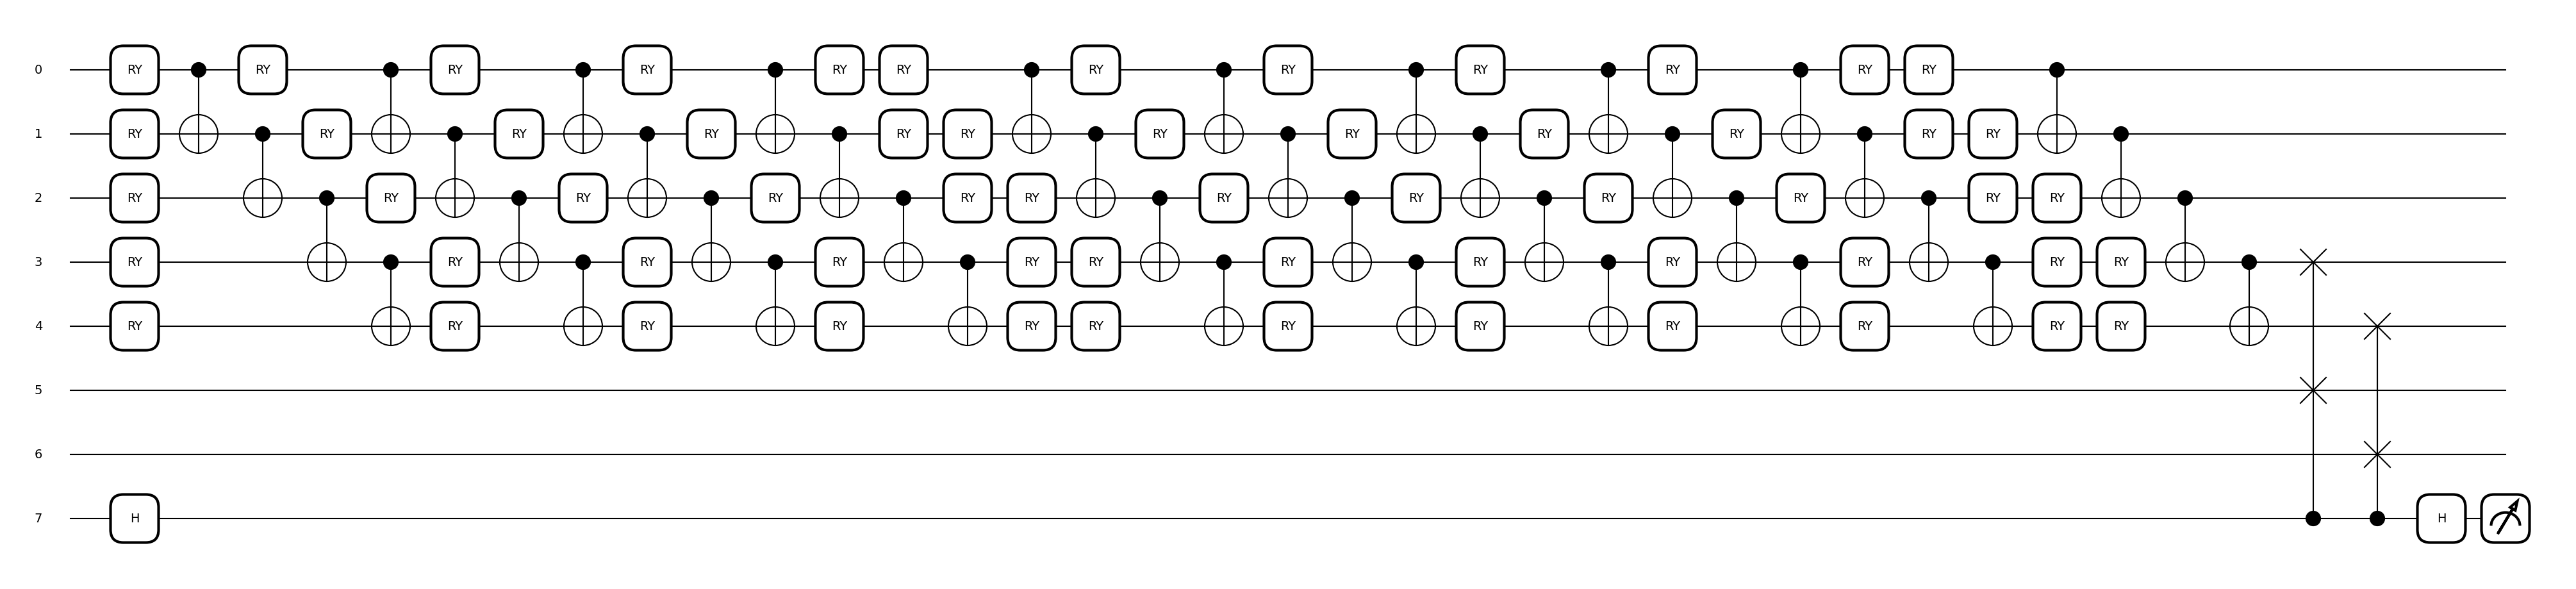

In [24]:
drawer = qml.draw_mpl(train_circuit)
print(drawer(params, X_train_transformed[0]))

In [25]:
def cost_function(weights):
    probabilities = [train_circuit(weights, transaction) for transaction in X_train_transformed]
    print(probabilities)
    cost_value = np.sum([p[1] for p in probabilities])/X_train_transformed.shape[0]
    return cost_value

In [26]:
cost_values = []
opt_weights = []
def callback(xk):
    cost_val = cost_function(xk)
    cost_values.append(cost_val)
    opt_weights.append(xk)
    print(f"Step {len(cost_values)}: cost = {cost_val:.4f}, params = {xk}")

In [27]:
minimize(cost_function, params, method='COBYLA', callback=callback, options={'maxiter': 500})
opt_weights = opt_weights[-1]

[tensor([0.71090436, 0.28909564], requires_grad=True), tensor([0.68327825, 0.31672175], requires_grad=True), tensor([0.69989919, 0.30010081], requires_grad=True), tensor([0.71013142, 0.28986858], requires_grad=True), tensor([0.66646156, 0.33353844], requires_grad=True), tensor([0.68548421, 0.31451579], requires_grad=True), tensor([0.68618105, 0.31381895], requires_grad=True), tensor([0.6721673, 0.3278327], requires_grad=True), tensor([0.69802485, 0.30197515], requires_grad=True), tensor([0.59330553, 0.40669447], requires_grad=True), tensor([0.71059877, 0.28940123], requires_grad=True), tensor([0.7086628, 0.2913372], requires_grad=True), tensor([0.7006317, 0.2993683], requires_grad=True), tensor([0.69216644, 0.30783356], requires_grad=True), tensor([0.70684854, 0.29315146], requires_grad=True), tensor([0.70881735, 0.29118265], requires_grad=True), tensor([0.68779651, 0.31220349], requires_grad=True), tensor([0.69489536, 0.30510464], requires_grad=True), tensor([0.69341596, 0.30658404], 

In [28]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights_quantum_anomaly_det.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights])

In [29]:
print(cost_values[-1])

0.03238082786632304


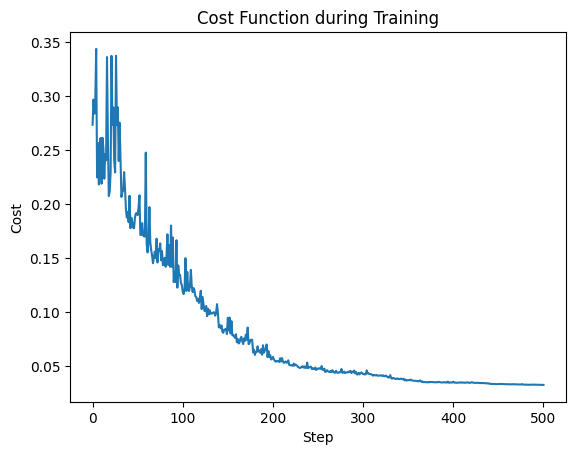

In [30]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [31]:
# Reset the qubits indicated by wir to zero
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [32]:
@qml.qnode(dev)
def autoencoder(opt_weights, transaction):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(transaction, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(opt_weights, n_wires_latent, n_wires_trash)
    reset_to_zero([3, 4])
    qml.adjoint(ansatz_custom_digits)(opt_weights, n_wires_latent, n_wires_trash)
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 5900x700 with 1 Axes>, <Axes: >)


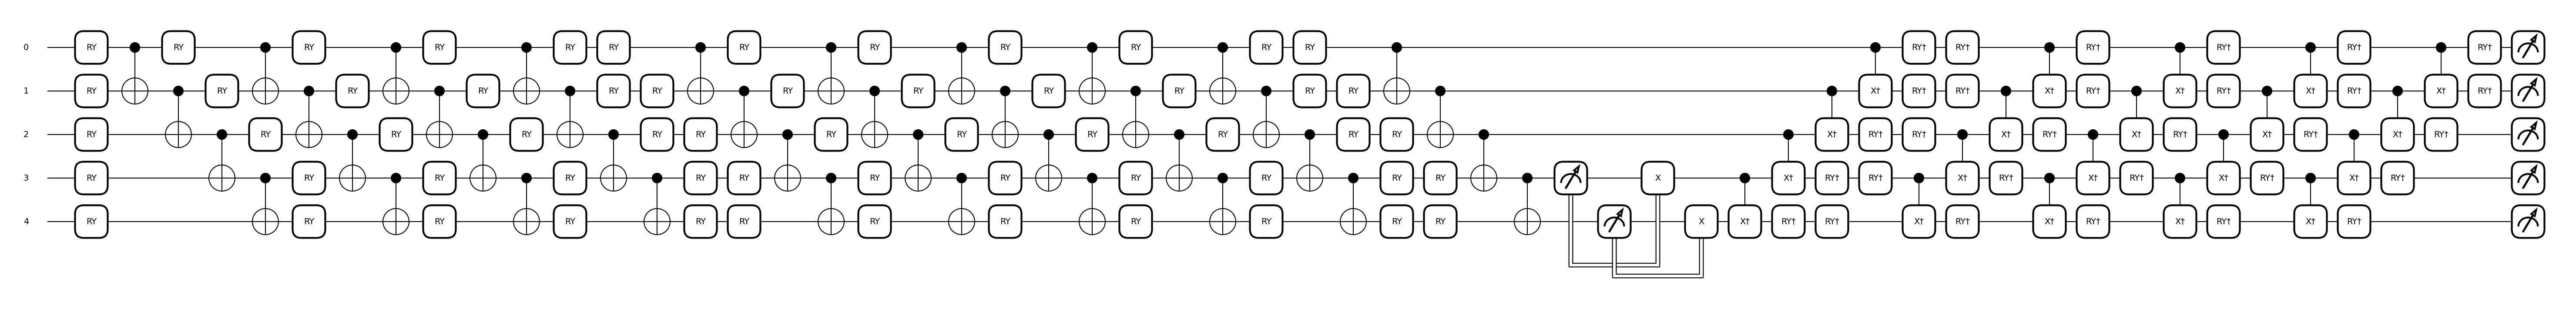

In [33]:
drawer_2 = qml.draw_mpl(autoencoder)
print(drawer_2(opt_weights, X_train_transformed[0]))

In [34]:
dev_validation = qml.device('default.qubit', wires=5)
@qml.qnode(dev)
def initial_state(transaction):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(transaction, n_wires_latent, n_wires_trash)
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

In [35]:
# Returns the mean of fidelity between the initial state and the autoencoder, computed on the validation set
def validation(opt_weights, X_validation_transformed):
    fid = []
    for i in X_validation_transformed:
        ae = autoencoder(opt_weights, i)
        initial = initial_state(i)
        fid.append(qml.math.fidelity(ae, initial))
    mean_fid = np.mean(fid)
    std_fid = np.std(fid)
    return mean_fid, std_fid

In [36]:
mean_fid, std_fid = validation(opt_weights, X_validation_transformed)
print(mean_fid, std_fid)

0.8675849445263779 0.21032720766535817


In [52]:
print(f"""Our testing set is composed as follows:

{X_test.Class.value_counts()}""")

Our testing set is composed as follows:

Class
0    60
1    40
Name: count, dtype: int64


In [62]:
labels = X_test['Class']
X_test.drop('Class', axis=1, inplace=True)

In [63]:
pipeline.transform(X_test);
X_test_transformed = pipeline.transform(X_test)

In [40]:
def test_unsupervised(opt_weights, X_test_transformed, mean_fid, std_fid):
    count = 0
    for i in X_test_transformed:
        ae = autoencoder(opt_weights, i)
        initial = initial_state(i)
        if qml.math.fidelity(ae, initial) < mean_fid-std_fid:
            count += 1
    return count

In [64]:
test_unsupervised(opt_weights, X_test_transformed, mean_fid, std_fid)

44

In [42]:
def test_supervised(opt_weights, X_test_transformed, mean_fid, std_fid, labels):
    correct_fraud = 0
    false_fraud = 0
    correct_clean = 0
    false_clean = 0
    
    for idx, i in enumerate(X_test_transformed):
        ae = autoencoder(opt_weights, i)
        initial = initial_state(i)
        if (qml.math.fidelity(ae, initial) < mean_fid-std_fid and labels[idx] == 1):
            correct_fraud += 1
        elif (qml.math.fidelity(ae, initial) < mean_fid-std_fid and labels[idx] == 0):
            false_fraud += 1
        elif (qml.math.fidelity(ae, initial) > mean_fid-std_fid and labels[idx] == 1):
            false_clean += 1
        else:
            correct_clean += 1
    return correct_fraud, false_fraud, correct_clean, false_clean

In [65]:
correct_fraud, false_fraud, correct_clean, false_clean = test_supervised(opt_weights, X_test_transformed, mean_fid, std_fid, labels)

In [66]:
print(f"correct_fraud: {correct_fraud}")
print(f"false_fraud: {false_fraud}")
print(f"correct_clean: {correct_clean}")
print(f"false_clean: {false_clean}")

correct_fraud: 40
false_fraud: 4
correct_clean: 56
false_clean: 0


In [67]:
accuracy = (correct_clean+correct_fraud)/(correct_clean+correct_fraud+false_clean+false_fraud)
precision = correct_fraud/(correct_fraud+false_fraud)
recall = correct_fraud/(correct_fraud+false_clean)
f1-score = 2*((precision*recall)/(precision+recall))

In [68]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"f1-score: {f1-score}")

Accuracy: 0.96
Precision: 0.9090909090909091
Recall: 1.0


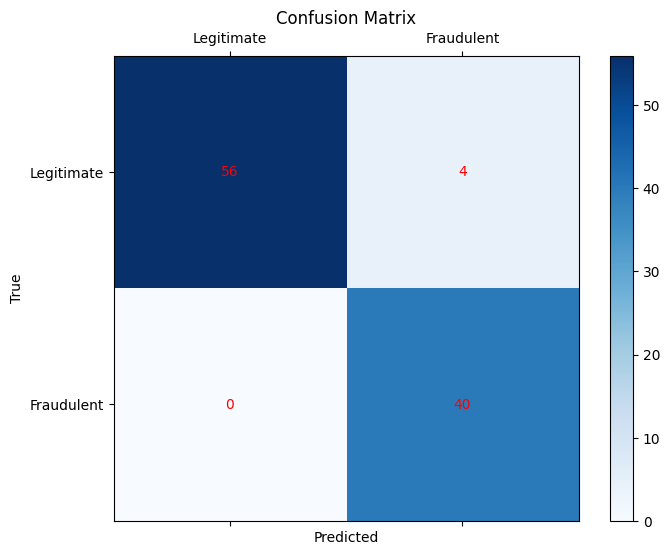

In [5]:
# Construct the confusion matrix
cm = np.array([[correct_clean, false_fraud],
               [false_clean, correct_fraud]])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.yticks([0, 1], ['Legitimate', 'Fraudulent'])

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [47]:
# 50 train, 50 test (30 - 20) ->
# correct_fraud: 20
# false_fraud: 3
# correct_clean: 27
# false_clean: 0
# Precision: 0.8695652173913043
# Recall: 1.0
# Validation 50: 0.7282940313406904 0.20308870679429836

# 100 train, 100 test (60 - 40) -> 
# correct_fraud: 40
# false_fraud: 6
# correct_clean: 54
# false_clean: 0
# Precision: 0.8695652173913043
# Recall: 1.0

# 100 train, 50 test (30 - 20) ->
# correct_fraud: 20
# false_fraud: 4
# correct_clean: 26
# false_clean: 0
# Precision: 0.8333333333333334
# Recall: 1.0

# seed(42) 50 train, 100 test (60 - 40) ->
# correct_fraud: 40
# false_fraud: 7
# correct_clean: 53
# false_clean: 0
# Precision: 0.851063829787234
# Recall: 1.0
# Validation 50: 0.6613140319656843 0.2513663623334964

# seed(42) 50 train, 100 test (60 - 40) ->
# correct_fraud: 40
# false_fraud: 10
# correct_clean: 50
# false_clean: 0
# Precision: 0.8
# Recall: 1.0
# Validation 100: 0.7059559249935456 0.22259287436677486

# seed(42) 100 train, 100 test (60 - 40) ->
# correct_fraud: 40
# false_fraud: 4
# correct_clean: 56
# false_clean: 0
# Precision: 0.9090909090909091
# Recall: 1.0
# Validation 50: 0.8305229123676001 0.20838311564701537
